# Neural Network (MLP)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.io import arff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import copy

In [6]:
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self, lr=.1, momentum=0, shuffle=True, hidden_layer_widths=None, num_epochs=5,
                 val_size=0, no_change_count=10):
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.val_size = val_size
        self.no_change_count = no_change_count

    def fit(self, X, y, initial_weights=None):
        self.initial_weights = initial_weights
        self.weights = self.initialize_weights(X, y)
            
        if self.val_size > 0:
            x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=self.val_size)
            non_change_count = 0
            self.val_mse = []
            self.train_mse = []
            self.train_acc = []
            self.val_acc = []
            for j in range(self.num_epochs):
                if non_change_count == self.no_change_count or j == (self.num_epochs-1):
                    break
                if self.shuffle: 
                    x_train, y_train = shuffle(x_train, y_train)
                for row in range(x_train.shape[0]):
                    self._forward(x_train, y_train, row)
                    self._backward(x_train, y_train, row)
                if j > 0:
                    if np.abs(self.score(x_val, y_val) - self.val_acc[-1]) < .1:
                        non_change_count = non_change_count + 1
                    else:
                        non_change_count = 0
                self.val_mse.append(self.mse(x_val, y_val))
                self.train_mse.append(self.mse(x_train, y_train))
                self.train_acc.append(self.score(x_train, y_train))
                self.val_acc.append(self.score(x_val, y_val)) 
        else:
            for j in range(self.num_epochs):
                if self.shuffle:
                    X, y = shuffle(X,y)
                for i in range(len(X)):
                    self._forward(X, y, i)
                    self._backward(X,y, i)
        
        self.final_num_epochs = j
        
    def _forward(self, X, y, indx):
        self.z_h, self.z_o = self.calc_z_o(X, y, indx)
          
    def _backward(self, X, y, indx):
        self.calc_node_deltas(X, y, indx)
        self.calc_wt_updates(X, y, indx)
        self.update_wts(X, y, indx)
                
    def initialize_weights(self, X, y):
        random_wts = []
        np.random.seed(3)
        layer1 = np.random.normal(0, 1, (X.shape[1], self.hidden_layer_widths[0]))
        layer2 = np.random.normal(0, 1, (self.hidden_layer_widths[-1] + 1, y.shape[1]))
        random_wts.extend([layer1, layer2])
        zero_wts = []
        layer3 = np.zeros((X.shape[1], self.hidden_layer_widths[0]))
        layer4 = np.zeros((self.hidden_layer_widths[-1] + 1, y.shape[1]))
        zero_wts.extend([layer3, layer4])
        self.prev_wt_changes = copy.deepcopy(zero_wts)
        if self.initial_weights == 'zero':
            return zero_wts
        else:
            return random_wts
    
    
    def calc_node_deltas(self, X, y, indx):
        self.delta_o = np.array([])
        for i in range(len(y[indx])):
            self.delta_o = np.append(self.delta_o, (y[indx][i] - self.z_o[i]) * (self.z_o[i])*(1-self.z_o[i]))
        self.delta_h = []
        for p in range(len(self.hidden_layer_widths)):
            self.delta_h_arr = np.array([])
            for i in range(self.hidden_layer_widths[p]):
                if p == 0:
                    self.delta_h_arr = np.append(self.delta_h_arr, (np.dot(self.delta_o, 
                                                                           self.weights[-1*(p+1)][i]) *
                                                                           (self.z_h[-1*(p+1)][i]) * 
                                                                           (1 - self.z_h[-1*(p+1)][i])))
                else:
                    self.delta_h_arr = np.append(self.delta_h_arr, (np.dot(self.delta_h[p-1], 
                                                                           self.weights[-1*(p+1)][i]) *
                                                                           (self.z_h[-1*(p+1)][i]) * 
                                                                           (1 - self.z_h[-1*(p+1)][i])))
            self.delta_h.append(self.delta_h_arr)
        self.delta_h.reverse()


    def calc_z_o(self, X, y, indx):
        net_h = []
        z_h = []
        for q in range(len(self.hidden_layer_widths)):
            net_h_arr = np.array([])
            z_h_arr = np.array([])
            for i in range(self.hidden_layer_widths[q]):
                if q == 0:
                    net_h_arr = np.append(net_h_arr, np.dot(X[indx], self.weights[q][:,i]))
                else:
                    net_h_arr = np.append(net_h_arr, np.dot(z_h, self.weights[q][:,i]))
                z_h_arr = np.append(z_h_arr, 1 / (1 + math.exp(-1*(net_h_arr[i]))))
            z_h_arr = np.append(z_h_arr, 1) # for bias node
            z_h.append(z_h_arr)
            net_h.append(net_h_arr)

        net_o = np.array([])
        for i in range(len(y[indx])):
            net_o = np.append(net_o, np.dot(z_h[-1], self.weights[-1][:,i]))

        z_o = np.array([])
        for i in range(len(net_o)):
            z_o = np.append(z_o, 1 / (1 + math.exp(-1*(net_o[i]))))
        return z_h, z_o 
            
        
    def calc_wt_updates(self, X, y, indx):
        self.wt_updates = []
        for whole in range(len(self.hidden_layer_widths)+1):
            if whole == 0:
                layer_updates = np.empty((0, self.hidden_layer_widths[0]))
                for outer in range(len(X[indx])):
                    row = np.array([])
                    for inner in range(self.hidden_layer_widths[0]):
                        row = np.append(row, self.lr * self.delta_h[whole][inner] * X[indx][outer])
                    layer_updates = np.vstack((layer_updates, row + (self.momentum * 
                                                                     self.prev_wt_changes[whole][outer])))
                self.wt_updates.append(layer_updates)
            elif whole == len(self.hidden_layer_widths):
                layer_updates = np.empty((0, len(y[0])))
                for outer in range(len(self.z_h[whole-1])):
                    row = np.array([])
                    for inner in range(len(y[0])):
                        row = np.append(row, self.lr * self.delta_o[inner] * self.z_h[whole-1][outer])
                    layer_updates = np.vstack((layer_updates, row + (self.momentum * 
                                                                     self.prev_wt_changes[whole][outer])))
                self.wt_updates.append(layer_updates)
            else:
                layer_updates = np.empty((0, self.hidden_layer_widths[whole-1]))
                for outer in range(len(self.z_h[whole-1])):
                    row = np.array([])
                    for inner in range(self.hidden_layer_widths[whole-1]):
                        row = np.append(row, self.lr * self.delta_h[whole][inner] * self.z_h[whole-1][outer])
                    layer_updates = np.vstack((layer_updates, row + (self.momentum * 
                                                                     self.prev_wt_changes[whole][outer])))
                self.wt_updates.append(layer_updates)  
            
            
    def update_wts(self, X, y, indx):
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] + self.wt_updates[i]
        self.prev_wt_changes = self.wt_updates  
        
        
    def predict(self, X, y):
        predictions = np.array([])
        for i in range(X.shape[0]):
            predictions = np.append(predictions, np.argmax(self.calc_z_o(X,y,i)[1]))
        return predictions
    
        
    def score(self, X, y):
        predictions = self.predict(X, y)
        actuals = np.array([])
        for i in range(y.shape[0]):
            actuals = np.append(actuals, np.argmax(y[i]))
        return sum(predictions == actuals) / len(predictions)
    
    
    def mse(self, X, y):
        sq_errs = np.array([])
        for i in range(X.shape[0]):
            sq_errs = np.append(sq_errs, sum((self.calc_z_o(X,y,i)[1]-y[i])**2))
        return sq_errs.mean()

    
    def get_weights(self):
        return self.weights
    
    
    def get_val_mse(self):
        return self.val_mse
    
    
    def get_train_mse(self):
        return self.train_mse
    
    
    def get_train_acc(self):
        return self.train_acc
    
    
    def get_val_acc(self):
        return self.val_acc
    
    
    def get_final_num_epochs(self):
        return self.final_num_epochs

Expected Results for 1 output node:

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$

Expected Results for 2 output nodes:

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

In [7]:
debug = pd.DataFrame(arff.loadarff('datasets/linsep2nonorigin.arff')[0])
debug['class'] = pd.to_numeric(debug['class'].str.decode('utf8'),downcast='float')

debug_x = debug.iloc[:,0:-1]
debug_x['bias'] = np.ones(len(debug_x))
debug_x = np.array(debug_x)

# debug_y = np.array(debug.iloc[:,-1]).reshape((len(debug),1)) # 1 output node
debug_y = np.array(pd.get_dummies(debug['class'])) # 2 output nodes

debug_MLP = MLP(lr=.1, momentum=0.5, shuffle=False, hidden_layer_widths=[4], num_epochs=10, val_size=0)
debug_MLP.fit(debug_x, debug_y, 'zero')

debug_MLP.get_weights()

[array([[-0.00018149, -0.00018149, -0.00018149, -0.00018149],
        [ 0.00157468,  0.00157468,  0.00157468,  0.00157468],
        [-0.00788218, -0.00788218, -0.00788218, -0.00788218]]),
 array([[ 0.01050642, -0.01050642],
        [ 0.01050642, -0.01050642],
        [ 0.01050642, -0.01050642],
        [ 0.01050642, -0.01050642],
        [ 0.02148778, -0.02148778]])]

In [8]:
# Load evaluation data
eval = pd.DataFrame(arff.loadarff('datasets/bank.arff')[0])
eval['class'] = pd.to_numeric(eval['class'].str.decode('utf8'),downcast='float')

eval_x = eval.iloc[:,0:-1]
eval_x['bias'] = np.ones(len(eval_x))
eval_y = eval.iloc[:,[-1]]

eval_x = np.array(eval_x)
eval_y = np.array(pd.get_dummies(eval['class']))

eval_MLP = MLP(lr=.1, momentum=.5, shuffle=False, hidden_layer_widths=[4], num_epochs=10, val_size=0)
eval_MLP.fit(eval_x, eval_y,'zero')

eval_MLP.get_weights()

[array([[ 1.63828721,  1.63828721,  1.63828721,  1.63828721],
        [ 1.09612249,  1.09612249,  1.09612249,  1.09612249],
        [ 1.23447594,  1.23447594,  1.23447594,  1.23447594],
        [ 0.39269487,  0.39269487,  0.39269487,  0.39269487],
        [-2.09316151, -2.09316151, -2.09316151, -2.09316151]]),
 array([[ 1.81695611, -1.81695611],
        [ 1.81695611, -1.81695611],
        [ 1.81695611, -1.81695611],
        [ 1.81695611, -1.81695611],
        [-4.17098071,  4.17098071]])]

## Neural Network on the Iris Classification problem.

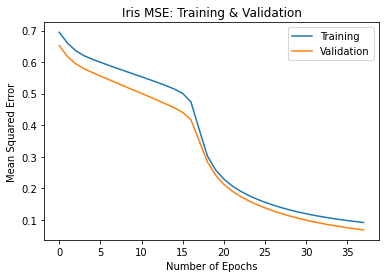

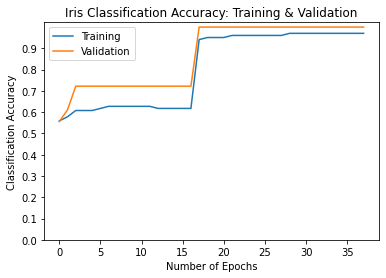

Test Set Accuracy:  0.9333333333333333


In [9]:
iris = pd.DataFrame(arff.loadarff('datasets/iris.arff')[0])
iris['class'] = iris['class'].str.decode('utf8')

iris_x = iris.iloc[:,0:-1]
iris_x['bias'] = np.ones(len(iris_x))
iris_y = pd.get_dummies(iris['class'])
iris_x = np.array(iris_x)
iris_y = np.array(iris_y)

iris_x_train, iris_x_test, iris_y_train, iris_y_test = train_test_split(iris_x, iris_y, test_size=0.2)

num_inputs = 2 * (iris_x.shape[1] - 1)
iris_MLP = MLP(lr=.1, momentum=0, shuffle=False, hidden_layer_widths=[num_inputs], num_epochs=100, val_size=.15,
               no_change_count=20)
iris_MLP.fit(iris_x_train, iris_y_train)

train_mse = iris_MLP.get_train_mse()
val_mse = iris_MLP.get_val_mse()
plt.plot(list(range(len(train_mse))),train_mse, val_mse)
plt.title('Iris MSE: Training & Validation')
plt.legend(['Training', 'Validation'])
plt.xlabel('Number of Epochs')
plt.xticks(np.arange(0,len(train_mse),5))
plt.ylabel('Mean Squared Error')
plt.savefig('iris_mse_train_val.jpg', dpi=300, bbox_inches='tight')
plt.show()

train_acc = iris_MLP.get_train_acc()
val_acc = iris_MLP.get_val_acc()
plt.plot(list(range(len(train_acc))), train_acc, val_acc)
plt.title('Iris Classification Accuracy: Training & Validation')
plt.legend(['Training', 'Validation'])
plt.xlabel('Number of Epochs')
plt.xticks(np.arange(0,len(train_acc),5))
plt.yticks(np.arange(0,1,.1))
plt.ylabel('Classification Accuracy')
plt.savefig('iris_acc_train_val.jpg', dpi=300, bbox_inches='tight')
plt.show()

print('Test Set Accuracy: ', iris_MLP.score(iris_x_test, iris_y_test))

## Neural Network on Vowel Dataset

In [10]:
vowel = pd.DataFrame(arff.loadarff('datasets/vowel.arff')[0])

vowel = vowel.drop('Train or Test', axis=1)
vowel = vowel.drop('Speaker Number', axis=1)
vowel = vowel.drop('Sex', axis=1)
vowel['Class'] = vowel['Class'].str.decode('utf8')

vowel = pd.get_dummies(vowel)

vowel_x = vowel.iloc[:,0:10]
vowel_y = vowel.iloc[:,10:]
vowel_x['bias'] = np.ones(len(vowel_x))

vowel_x = np.array(vowel_x)
vowel_y = np.array(vowel_y)

# Use random 80/20 splits of the data for the training/test set.
vowel_x_train, vowel_x_test, vowel_y_train, vowel_y_test = train_test_split(vowel_x, vowel_y, test_size=0.2)

# Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
num_inputs = 2*(vowel_x.shape[1] - 1)

In [11]:
vowel_MLP1 = MLP(lr=.05, momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP1.fit(vowel_x_train, vowel_y_train)
val_mse1 = vowel_MLP1.get_val_mse()

In [12]:
vowel_MLP2 = MLP(lr=.1,momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP2.fit(vowel_x_train, vowel_y_train)
val_mse2 = vowel_MLP2.get_val_mse()

In [ ]:
vowel_MLP3 = MLP(lr=.2,momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP3.fit(vowel_x_train, vowel_y_train)
val_mse3 = vowel_MLP3.get_val_mse()

In [ ]:
vowel_MLP4 = MLP(lr=.3,momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP4.fit(vowel_x_train, vowel_y_train)
val_mse4 = vowel_MLP4.get_val_mse()

In [ ]:
vowel_MLP5 = MLP(lr=.4,momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP5.fit(vowel_x_train, vowel_y_train)
val_mse5 = vowel_MLP5.get_val_mse()

In [ ]:
vowel_MLP6 = MLP(lr=.5,momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP6.fit(vowel_x_train, vowel_y_train)
val_mse6 = vowel_MLP6.get_val_mse()

In [ ]:
vowel_MLP7 = MLP(lr=.6,momentum=0, num_epochs=100, hidden_layer_widths=[num_inputs], val_size=.15, 
                 no_change_count=100)
vowel_MLP7.fit(vowel_x_train, vowel_y_train)
val_mse7 = vowel_MLP7.get_val_mse()

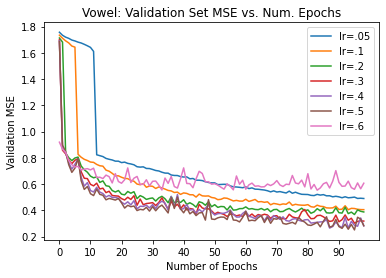

In [ ]:
val_mse = [val_mse1, val_mse2, val_mse3, val_mse4, val_mse5, val_mse6, val_mse7]
len_val_mse = [len(val_mse1), len(val_mse2), len(val_mse3), len(val_mse4), len(val_mse5), len(val_mse6), 
               len(val_mse7)]
tmp = list(range(len(val_mse[np.argmax(len_val_mse)])))

for val in val_mse:
    plt.plot(val)
plt.title('Vowel: Validation Set MSE vs. Num. Epochs')
plt.legend(['lr=.05', 'lr=.1', 'lr=.2', 'lr=.3', 'lr=.4', 'lr=.5', 'lr=.6'])
plt.xlabel('Number of Epochs')
plt.xticks(np.arange(0,len(tmp),10))
plt.ylabel('Validation MSE')
plt.savefig('vowel_val_mse_epochs.jpg', dpi=300, bbox_inches='tight')

In [ ]:
min_val_mse = [min(val_mse1), min(val_mse2), min(val_mse3), min(val_mse4), min(val_mse5), min(val_mse6),
              min(val_mse7)]
lr_list = [.05, .1, .2, .3, .4, .5, .6]

print('Lowest Validation MSE with lr:', lr_list[np.argmin(min_val_mse)], 'with MSE: ', 
      min_val_mse[np.argmin(min_val_mse)])

Lowest Validation MSE with lr: 0.5 with MSE:  0.25119989125036235


In [473]:
print('Test Accuracy: ', vowel_MLP7.score(vowel_x_test, vowel_y_test))

Test Accuracy:  0.5959595959595959


## 3.1 (5%) Working with the Vowel Dataset - Intuition

The vowel dataset is a dataset of 10,000 samples of 12 features. The features are the 12 formant frequencies of the vowels. The labels are the 11 vowels. The dataset is available at [https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)
Varying learning rates shows how audacious the model is in adjusting its weights. Low learning rate means that the model is taking small steps each time; large learning rate, on the other hand, means the model is taking large steps each time.

#### Vowel harder than Banknote
For one, the vowel data set has much more input features and output features; thus, there's just more to learn. For two, the vowel dataset doesn't have extremely clear predictable patterns like the iris dataset has. There's more noise in the data, so it's more difficult for the model to adjust weights to find the perfect match.

##### VOWEL
baseline: 24%
best test: 62% is the highest test accuracy I achieved.

##### IRIS
baseline: 60%
best test: 100% is the highets test accuracy I achieved.


I dropped the 3 that are mentioned above (Train/test, speaker, gender) because they all didn't seem to be releveant in predicting the output. The one that was questionable was the gender, but the speaker and train/test were for sure not good at helping us predict the vowel sound output.

## Vowel Dataset - Multi-layered


In [73]:
vowel_MLP_hl_1 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[1], val_size=.15, no_change_count=5)
vowel_MLP_hl_1.fit(vowel_x_train, vowel_y_train)
val_mse_h1_1 = vowel_MLP_hl_1.get_val_mse()
train_mse_hl_1 = vowel_MLP_hl_1.get_train_mse()
test_acc_h1_1 = vowel_MLP_hl_1.score(vowel_x_test, vowel_y_test)

In [74]:
vowel_MLP_hl_2 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[2], val_size=.15, no_change_count=5)
vowel_MLP_hl_2.fit(vowel_x_train, vowel_y_train)
val_mse_hl_2 = vowel_MLP_hl_2.get_val_mse()
train_mse_hl_2 = vowel_MLP_hl_2.get_train_mse()
test_acc_hl_2 = vowel_MLP_hl_2.score(vowel_x_test, vowel_y_test)

In [75]:
vowel_MLP_hl_3 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[4], val_size=.15, no_change_count=5)
vowel_MLP_hl_3.fit(vowel_x_train, vowel_y_train)
val_mse_hl_3 = vowel_MLP_hl_3.get_val_mse()
train_mse_hl_3 = vowel_MLP_hl_3.get_train_mse()
test_acc_hl_3 = vowel_MLP_hl_3.score(vowel_x_test, vowel_y_test)

In [76]:
vowel_MLP_hl_4 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[8], val_size=.15, no_change_count=5)
vowel_MLP_hl_4.fit(vowel_x_train, vowel_y_train)
val_mse_h1_4 = vowel_MLP_hl_4.get_val_mse()
train_mse_hl_4 = vowel_MLP_hl_4.get_train_mse()
test_acc_h1_4 = vowel_MLP_hl_4.score(vowel_x_test, vowel_y_test)

In [77]:
vowel_MLP_hl_5 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[16], val_size=.15, no_change_count=5)
vowel_MLP_hl_5.fit(vowel_x_train, vowel_y_train)
val_mse_h1_5 = vowel_MLP_hl_5.get_val_mse()
train_mse_hl_5 = vowel_MLP_hl_5.get_train_mse()
test_acc_h1_5 = vowel_MLP_hl_5.score(vowel_x_test, vowel_y_test)

In [78]:
vowel_MLP_hl_6 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[32], val_size=.15, no_change_count=5)
vowel_MLP_hl_6.fit(vowel_x_train, vowel_y_train)
val_mse_h1_6 = vowel_MLP_hl_6.get_val_mse()
train_mse_hl_6 = vowel_MLP_hl_6.get_train_mse()
test_acc_h1_6 = vowel_MLP_hl_6.score(vowel_x_test, vowel_y_test)

In [79]:
vowel_MLP_hl_7 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[64], val_size=.15, no_change_count=5)
vowel_MLP_hl_7.fit(vowel_x_train, vowel_y_train)
val_mse_h1_7 = vowel_MLP_hl_7.get_val_mse()
train_mse_hl_7 = vowel_MLP_hl_7.get_train_mse()
test_acc_h1_7 = vowel_MLP_hl_7.score(vowel_x_test, vowel_y_test)

In [80]:
vowel_MLP_hl_8 = MLP(lr=.6, momentum=0, num_epochs=50, hidden_layer_widths=[128], val_size=.15, no_change_count=5)
vowel_MLP_hl_8.fit(vowel_x_train, vowel_y_train)
val_mse_hl_8 = vowel_MLP_hl_8.get_val_mse()
train_mse_hl_8 = vowel_MLP_hl_8.get_train_mse()
test_acc_hl_8 = vowel_MLP_hl_8.score(vowel_x_test, vowel_y_test)

In [453]:
test_acc_list = np.array([test_acc_h1_1, test_acc_hl_2, test_acc_hl_3, test_acc_h1_4, test_acc_h1_5,
                          test_acc_h1_6, test_acc_h1_7, test_acc_hl_8])
print('The ',np.argmax(test_acc_list)+1,'\'th model did best with highest accuracy: ', 
      test_acc_list[np.argmax(test_acc_list)])
num_hid_nodes = 2 ** np.arange(8)

df = pd.DataFrame(np.column_stack((num_hid_nodes, test_acc_list)), columns = ['Hidden Nodes', 'Test Accuracy'])
df

The  7 'th model did best with highest accuracy:  0.6212121212121212


,Hidden Nodes,Test Accuracy
0,1.0,0.070707
1,2.0,0.111111
2,4.0,0.202020
3,8.0,0.378788
4,16.0,0.409091
5,32.0,0.520202
6,64.0,0.621212
7,128.0,0.262626


Lowest MSE was with 64 hidden nodes with MSE:  0.511413158806552


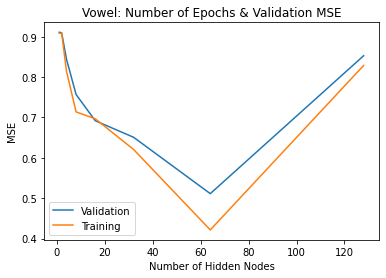

In [382]:
val_mse_min_list = [min(val_mse_h1_1), min(val_mse_hl_2), min(val_mse_hl_3), min(val_mse_h1_4),
                    min(val_mse_h1_5), min(val_mse_h1_6), min(val_mse_h1_7), min(val_mse_hl_8)]

num_hidden_nds = 2**np.arange(8)

train_mse_min_list = [min(train_mse_hl_1), min(train_mse_hl_2), min(train_mse_hl_3), min(train_mse_hl_4),
                      min(train_mse_hl_5), min(train_mse_hl_6), min(train_mse_hl_7), min(train_mse_hl_8)]

print('Lowest MSE was with', num_hidden_nds[np.argmin(val_mse_min_list)],'hidden nodes with MSE: ',
      val_mse_min_list[np.argmin(val_mse_min_list)])

hidden_nodes_vs_val_mse = []
hidden_nodes_vs_train_mse = []
for i in range(len(val_mse_min_list)):
    num_hidden_nodes = 2**i
    hidden_nodes_vs_val_mse.append((num_hidden_nodes, val_mse_min_list[i]))
    hidden_nodes_vs_train_mse.append((num_hidden_nodes, train_mse_min_list[i]))
    
hidden_nodes, val_mses = zip(*hidden_nodes_vs_val_mse)
hidden_nodes, train_mses = zip(*hidden_nodes_vs_train_mse)
plt.plot(hidden_nodes, val_mses)
plt.plot(hidden_nodes, train_mses)
plt.legend(['Validation', 'Training'])
plt.title('Vowel: Number of Epochs & Validation MSE')
plt.xlabel('Number of Hidden Nodes')
plt.ylabel('MSE')
plt.savefig('vowel_epochs_val_mse.jpg', dpi=300, bbox_inches='tight')
plt.show()

My test accuarcy slowly climbed as I raised the number of hidden nodes in the one hidden layer that I was using. That was until I doubled the nodes and reached 128 hidden nodes. At which point, the accuracy dropped steeply. Thus the optimal number of hidden nodes (in powers of 2) is 64.

## Vowel Dataset - Momentum

In [474]:
vowel_MLP_mom_1 = MLP(lr=.6, momentum=0, num_epochs=100, hidden_layer_widths=[64], val_size=.15, 
                      no_change_count=5)
t1 = time.time()
vowel_MLP_mom_1.fit(vowel_x_train, vowel_y_train)
t2 = time.time()
val_mse_mom_1 = vowel_MLP_mom_1.get_val_mse()
train_mse_mom_1 = vowel_MLP_mom_1.get_train_mse()
test_acc_mom_1 = vowel_MLP_mom_1.score(vowel_x_test, vowel_y_test)
num_epochs_till_converge_1 = vowel_MLP_mom_1.get_final_num_epochs()
print('time to complete:', t2-t1)

time to complete: 39.16600799560547


In [487]:
vowel_MLP_mom_2 = MLP(lr=.6, momentum=0.2, num_epochs=100, hidden_layer_widths=[64], val_size=.15, 
                      no_change_count=5)
vowel_MLP_mom_2.fit(vowel_x_train, vowel_y_train)
val_mse_mom_2 = vowel_MLP_mom_2.get_val_mse()
train_mse_mom_2 = vowel_MLP_mom_2.get_train_mse()
test_acc_mom_2 = vowel_MLP_mom_2.score(vowel_x_test, vowel_y_test)
num_epochs_till_converge_2 = vowel_MLP_mom_2.get_final_num_epochs()

In [488]:
vowel_MLP_mom_3 = MLP(lr=.6, momentum=0.4, num_epochs=100, hidden_layer_widths=[64], val_size=.15, 
                      no_change_count=5)
vowel_MLP_mom_3.fit(vowel_x_train, vowel_y_train)
val_mse_mom_3 = vowel_MLP_mom_3.get_val_mse()
train_mse_mom_3 = vowel_MLP_mom_3.get_train_mse()
test_acc_mom_3 = vowel_MLP_mom_3.score(vowel_x_test, vowel_y_test)
num_epochs_till_converge_3 = vowel_MLP_mom_3.get_final_num_epochs()

In [489]:
vowel_MLP_mom_4 = MLP(lr=.6, momentum=0.6, num_epochs=100, hidden_layer_widths=[64], val_size=.15, 
                      no_change_count=5)
vowel_MLP_mom_4.fit(vowel_x_train, vowel_y_train)
val_mse_mom_4 = vowel_MLP_mom_4.get_val_mse()
train_mse_mom_4 = vowel_MLP_mom_4.get_train_mse()
test_acc_mom_4 = vowel_MLP_mom_4.score(vowel_x_test, vowel_y_test)
num_epochs_till_converge_4 = vowel_MLP_mom_4.get_final_num_epochs()

In [490]:
vowel_MLP_mom_5 = MLP(lr=.6, momentum=0.8, num_epochs=100, hidden_layer_widths=[64], val_size=.15, 
                      no_change_count=5)
vowel_MLP_mom_5.fit(vowel_x_train, vowel_y_train)
val_mse_mom_5 = vowel_MLP_mom_5.get_val_mse()
train_mse_mom_5 = vowel_MLP_mom_5.get_train_mse()
test_acc_mom_5 = vowel_MLP_mom_5.score(vowel_x_test, vowel_y_test)
num_epochs_till_converge_5 = vowel_MLP_mom_5.get_final_num_epochs()

In [491]:
test_acc_mom_list = np.array([test_acc_mom_1, test_acc_mom_2, test_acc_mom_3, test_acc_mom_4, test_acc_mom_5])
print('The ',np.argmax(test_acc_mom_list)+1,'\'st model did best with highest accuracy:',
      test_acc_mom_list[np.argmax(test_acc_mom_list)])
momentum_term = np.arange(0,1,.2)

df = pd.DataFrame(np.column_stack((momentum_term, test_acc_mom_list)), columns = ['momentum_term', 'accuracy'])
df

The  3 'st model did best with highest accuracy: 0.4595959595959596


,momentum_term,accuracy
0,0.0,0.424242
1,0.2,0.439394
2,0.4,0.459596
3,0.6,0.373737
4,0.8,0.085859


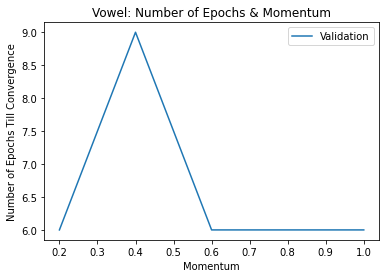

In [492]:
final_num_epochs = [num_epochs_till_converge_1, num_epochs_till_converge_2, num_epochs_till_converge_3,
                    num_epochs_till_converge_4, num_epochs_till_converge_5]

momentum_vs_final_num_epochs = []
for i in range(len(final_num_epochs)):
    momentum_term = ((i+1)*.2)
    momentum_vs_final_num_epochs.append((momentum_term, final_num_epochs[i]))
    
momentum_term, num_epochs = zip(*momentum_vs_final_num_epochs)
plt.plot(momentum_term, num_epochs)
plt.legend(['Validation'])
plt.title('Vowel: Number of Epochs & Momentum')
plt.xlabel('Momentum')
plt.ylabel('Number of Epochs Till Convergence')
plt.savefig('vowel_epochs_to_converge.jpg', dpi=300, bbox_inches='tight')
plt.show()

Momentum, in short, determines how much the current weight updates should consider the past weight updates in its decision for how much to change the weights. If the last one is to be heavily considered, then a high momentum coefficient is put into the model. For me, I found that the best momentum coefficient for accuracy was 0, but the best momentum coefficient for convergence was .8.

## Compared to Scikit-learn

In [477]:
# Default Values Iris
irisMLP = MLPClassifier(hidden_layer_sizes=(100), activation='relu', solver='adam', learning_rate_init=.001, 
                      max_iter=200, momentum=.09, nesterovs_momentum=True, early_stopping=False)

t1 = time.time()
irisMLP.fit(iris_x_train, iris_y_train)
t2 = time.time()

print('iris score: ', irisMLP.score(iris_x_test, iris_y_test))
print('iris training time: ', t2-t1)

iris score:  0.8
iris training time:  0.09916186332702637


In [486]:
# Default Values Vowel
vowelMLP = MLPClassifier(hidden_layer_sizes=(100), activation='relu', solver='adam', learning_rate_init=.001, 
                      max_iter=200, momentum=.9, nesterovs_momentum=True, early_stopping=False)

t1 = time.time()
vowelMLP.fit(vowel_x_train, vowel_y_train)
t2 = time.time()

print('vowel score: ', vowelMLP.score(vowel_x_test, vowel_y_test))
print('vowel training time: ', t2-t1)

vowel score:  0.35858585858585856
vowel training time:  0.4295389652252197


In [398]:
# Tweaked Values Iris
irisMLP = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', learning_rate_init=.001, 
                      max_iter=4000, momentum=.9, nesterovs_momentum=True, early_stopping=False)

t1 = time.time()
irisMLP.fit(iris_x_train, iris_y_train)
t2 = time.time()

print('tweaked iris score: ', irisMLP.score(iris_x_test, iris_y_test))
print('tweaked iris training time: ', t2-t1)

tweaked iris score:  1.0
tweaked iris training time:  0.4317467212677002


In [399]:
# Tweaked Values Vowel
vowelMLP = MLPClassifier(hidden_layer_sizes=(100, 100), activation='tanh', solver='adam', 
                         learning_rate_init=.001, max_iter=4000, momentum=.09, nesterovs_momentum=False,
                         early_stopping=False)

t1 = time.time()
vowelMLP.fit(vowel_x_train, vowel_y_train)
t2 = time.time()

print('tweaked vowel score: ', vowelMLP.score(vowel_x_test, vowel_y_test))
print('tweaked vowel training time: ', t2-t1)

tweaked vowel score:  0.9545454545454546
tweaked vowel training time:  5.740313768386841


For starters, the sklearn MLPClassifier is remarkably faster than my MLP class. That should almost go without saying, of course. But all in all the accuracies that it is getting through successive runs is similar to the accuracies that I was getting. I'm sure there are more things going on under the hood, but their model is very fast and accurate.

## 4.2 Grid / Random Search for HPO

In [400]:
# Potential Values
hidden_layer_sizes = np.arange(10,110,10)
activation = np.array(['identity', 'logistic', 'tanh', 'relu'])
solver = np.array(['lbfgs', 'sgd', 'adam'])
learning_rate = np.array([.001, .002, .0015, .0025])
max_iter = np.arange(200, 1000, 100)
momentum = np.array([.5, .6, .7, .8, .9])
nesterovs_momentum = np.array(['False', 'True'])
early_stopping = np.array(['False', 'True'])


for i in range(4):
    
    print('ROUND', i+1)
    
    tmp_hidden_layer_sizes = np.random.choice(hidden_layer_sizes)
    tmp_activation = np.random.choice(activation)
    tmp_solver = np.random.choice(solver)
    tmp_learning_rate = np.random.choice(learning_rate)
    tmp_max_iter = np.random.choice(max_iter)
    tmp_momentum = np.random.choice(momentum)
    tmp_nesterovs_momentum = np.random.choice(nesterovs_momentum)
    tmp_early_stopping = np.random.choice(early_stopping)
    
    myMLP = MLPClassifier(hidden_layer_sizes=(tmp_hidden_layer_sizes), activation=tmp_activation, 
                          solver=tmp_solver, learning_rate_init=tmp_learning_rate, max_iter=tmp_max_iter,
                          momentum=tmp_momentum, nesterovs_momentum=False, 
                          early_stopping=False)
    
    t1 = time.time()
    myMLP.fit(iris_x_train, iris_y_train)
    t2 = time.time()
    
    print('hidden_layer_sizes:', tmp_hidden_layer_sizes)
    print('activation:', tmp_activation)
    print('solver:', tmp_solver)
    print('learning_rate:', tmp_learning_rate)
    print('max_iter:', tmp_max_iter)
    print('momentum:', tmp_momentum)
    print('nesterovs_momentum:', True)
    print('early_stopping:', False)
    print('score:', myMLP.score(iris_x_test, iris_y_test))
    print('training time:', t2-t1, '\n')

ROUND 1
hidden_layer_sizes: 50
activation: logistic
solver: adam
learning_rate: 0.0015
max_iter: 800
momentum: 0.5
nesterovs_momentum: True
early_stopping: False
score: 1.0
training time: 0.23274803161621094 

ROUND 2
hidden_layer_sizes: 100
activation: relu
solver: adam
learning_rate: 0.001
max_iter: 900
momentum: 0.6
nesterovs_momentum: True
early_stopping: False
score: 1.0
training time: 0.2457718849182129 

ROUND 3
hidden_layer_sizes: 100
activation: relu
solver: lbfgs
learning_rate: 0.002
max_iter: 500
momentum: 0.7
nesterovs_momentum: True
early_stopping: False
score: 0.9666666666666667
training time: 0.11307716369628906 

ROUND 4
hidden_layer_sizes: 40
activation: tanh
solver: sgd
learning_rate: 0.002
max_iter: 200
momentum: 0.9
nesterovs_momentum: True
early_stopping: False
score: 0.5666666666666667
training time: 0.05079174041748047 



Running multiple iterations on this, my best accuracy was 93% on the iris dataset with the following hyperparameters:\\

hidden_layer_sizes: 100\
activation: relu\
solver: adam\
learning_rate: 0.0025\
max_iter: 300\
momentum: 0.9\
nesterovs_momentum: True\
early_stopping: False\
score: 0.9333333333333333\
training time: 0.11300826072692871 \